# Uncertainty in the predictor variables

In the [previous notebook](Target_Uncertainty.ipynb) we discussed how to deal with the cases when the target value is not accurate, according to the person who labels the data. Very commonly it is dropped from consideration, but in many cases we can keep the case in the data set, but adjust the cost function so that this case will influence the result to a lower degree, than the trustworthy cases.

In this notebook we consider the case when the value of predictor variable cannot be trusted, as opposed to the value of the target variable, like in the previous notebook. 

For simplicity we consider a simple linear regression problem with one numerical predictor. We will model the uncertainty in the predictor value using Normal distribution. The belief net for this dependency is displayed below:
<img src="belief_net_numerical.png">
Here y is observed target, x is observed (but untrusted predictor), $\xi$ is the true, but unobserved value of the predictor variable and $\theta$ is the parameter of the linear regression model. Since $\xi$ is unobserved, we should marginalize it out.

$$ p(y | x,\theta,\sigma) = \sum_{\xi} { p( y, \xi | x, \theta, \sigma) } 
= \sum_{\xi} { p( y | x, \theta, \sigma, \xi) p(\xi | x, \sigma) }  \tag{1} $$

Here we used Bayes rule regarding the joint probability. The values of probabilities are the follow:

$$ p( y | \theta, \sigma, \xi) = \frac{1}{\sqrt{2 \pi \sigma^2}} 
e^{-\frac{(y-\theta \xi)^2}{2\sigma^2}} \tag{2}$$

$$ p(\xi | x, \sigma) = p(x | \xi, \sigma) = \sqrt{\frac{\tau}{2 \pi \sigma^2}}
e^{-\frac{(x-\xi)^2\tau}{2\sigma^2}} \tag{3}$$

Here we used Bayes rule again and assumed flat prior on $\xi$. We introduced measure of certainty $\tau$. When it is infinity we are certain about the value of predictor, when it is small the uncertainty is very large and the variable cannot be trusted. This value can be set during data labeling.

When we marginalize out the unobserved variable $\xi$ by integrating the joint probability over the entire range of $\xi$, we will get the following probability (I will spare you details of integration):

$$ p(y|x, \theta, \sigma, \tau) = \sqrt{\frac{1}{(1+\frac{\theta^2}{\tau})2\pi\sigma^2}} 
exp\bigg(-\frac{(y-\theta x)^2}{2 \sigma^2 (1+\frac{\theta^2}{\tau})}\bigg) \tag{4}$$


The loss function (for a single case) is the negative log of this probability, multiplied by $\sigma^2$ for simplicity:

$$ \mathscr{L} = \frac{1}{2}\sigma^2 log\big(1+\frac{\theta^2}{\tau}\big) + 
\frac{(y - \theta x)^2}{2\big(1+\frac{\theta^2}{\tau}\big)} \tag{5} $$

The first term works as a regularization term. Indeed, for a very high $\tau$ it can be approximated by:

$$ \frac{\sigma^2}{2\tau} \theta^2 $$ 

which is the L2 regularization term. It is interesting how we derived L2 regularization based on predictor's uncertainty. We see that the higher the uncertainty the higher regularization that we need to apply to out model.

The second term is a modified loss function for the linear regression. The additional factor in the denominator makes it a non-quadratic function of $\theta$. We will plot the loss functions for different values of $\sigma$ and $\tau$

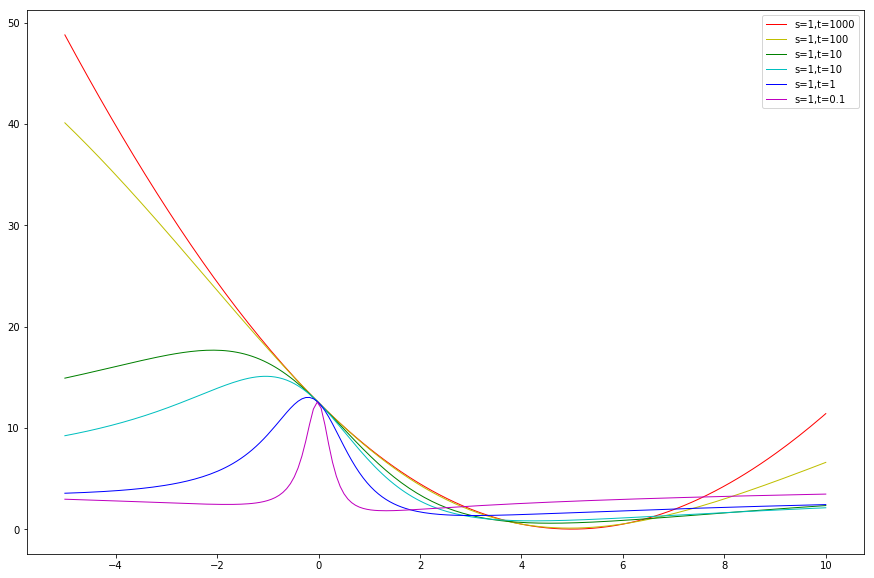

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = 1
y = 5

def loss_function(theta, sigma, tau):
    reg_dem = 1 + theta**2/tau
    return 1/2*sigma**2 * np.log(reg_dem) + (y-theta*x)**2/2/reg_dem

plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots(1, 1)
theta = np.linspace(-5, 10, 200)
ax.plot(theta, loss_function(theta, 1,1000), 'r-', lw=1, alpha=1, label='s=1,t=1000')
ax.plot(theta, loss_function(theta, 1,100), 'y-', lw=1, alpha=1, label='s=1,t=100')
ax.plot(theta, loss_function(theta, 1,10), 'g-', lw=1, alpha=1, label='s=1,t=10')
ax.plot(theta, loss_function(theta, 1,5), 'c-', lw=1, alpha=1, label='s=1,t=10')
ax.plot(theta, loss_function(theta, 1,1), 'b-', lw=1, alpha=1, label='s=1,t=1')
ax.plot(theta, loss_function(theta, 1,0.1), 'm-', lw=1, alpha=1, label='s=1,t=0.1')
plt.legend();

The first thing we see, is that the loss function is non-convex, and may have two local minima. This could be a problem if we are using Gradient Descent to learn the most likely parameters. 

We see also, that for high trust factor $\tau$ the loss function is almost quadratic with the minimum at the expected value 5. But as the uncertainty increases, the minimum shifts to the lower values of $\theta$, and the curve does not resemble parabola anymore. 

## Dealing with categorical features
If you have categorical features with uncertain values, these too can be used in a model, which have to be adjusted to handle uncertainty. If we use one-hot encoding of the categorical feature, the likelihood function (1) has to be rewritten as:

$$ p( y | c, \sigma, \xi) = \frac{1}{\sqrt{2 \pi \sigma^2}} 
e^{-\frac{(y- c_\xi)^2}{2\sigma^2}} \tag{6}$$

Here instead of $\theta$ we introduced parameters c, one for each value of the category. Then $c_\xi$ is the value of the categorical parameter for the category value $\xi$

To model uncertainty in the predictor value we have to introduce a uncertainty matrix U, the elements of which are conditional probabilities:

$$ U_{\xi x} = p(\xi|x) $$

Then, marginalizing out $\xi$, we can get the posterior probability as:

$$ p(y|c, \sigma, x) \propto \sum_\xi {U_{\xi x} e^{-\frac{(y- c_\xi)^2}{2\sigma^2}}} \tag{7} $$

The values of the matrix U are set during labeling. However, for the categories with too many values it is difficult to estimate correctly all the values of U because there are just too many of them! It is often necessary to use an approximation. An example of such approximation could be a symmetric approximation:

$$ U_{\xi x}= 
\begin{cases}
    u,& \text{if } x =  \xi\\
    \frac{1 - u}{N - 1},              & \text{otherwise}
\end{cases} $$

Here N is the number of categories. Then (7) can be simplified:

$$ p(y|c, \sigma, x) \propto 
 u e^{-\frac{(y- c_x)^2}{2\sigma^2}} +
\frac{1 - u}{N - 1} \sum_{\xi \ne x} {e^{-\frac{(y- c_\xi)^2}{2\sigma^2}}} $$

## Conclusion

There are cases, when the target value can be trusted, but one or more predictor values are uncertain. These cases can be identified as such during data labeling, and the degree of uncertainty should be used in the model to correct the prediction. We used simple Bayesian technique for doing so. We demonstrated, that the small degree of uncertainty results in L2 regularization term. For categorical features a similar technique was used. We considered only regression problem. We can use a similar technique for classification problems as well, but the mathematical results may be different.